# Change on Adding Theories
Study how much predictions change on adding Phyisochemical Theories (PCTs).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import json
import gzip
import os
import re

## Load in the datasets
We use 2 datasets, the results from a search for new glasses before and after adding the theories

In [2]:
def load_data(path, prefix):
    """Load in the composition and liklihood of forming a glass
    
    :param path: str, path to dataset"""
    
    with gzip.open(path, 'rt') as fp:
        temp = json.load(fp)
    
    return pd.DataFrame({
        'composition': [e['composition'] for e in temp['entries']],
        'probability_%s'%prefix: [e['class']['probabilities'][0] for e in temp['entries']]
    })
before = load_data(os.path.join('..', '2_with-processing-method', 'new-glasses.json.gz'), 'before')

In [3]:
after = load_data('new-glasses.json.gz', 'after')

## Measure change in predictions
We want to see how the addition of theories changes individual predictions

In [4]:
data = before.merge(after, on='composition', copy=False)
del before, after

In [5]:
data.head()

,composition,probability_before,probability_after
0,Al,0.0425,0.066970
1,B,0.1300,0.159906
2,Ba,0.1425,0.128562
3,Ca,0.0650,0.060000
4,Co,0.0450,0.070000


In [6]:
data['change'] = data['probability_before'] - data['probability_after']

In [7]:
data['change_abs'] = data['change'].apply(abs)

Make a histogram

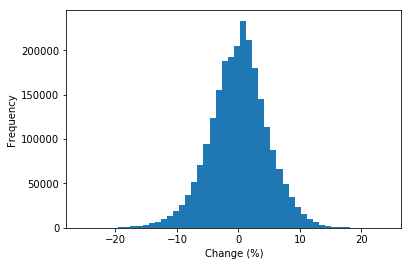

In [8]:
fig, ax = plt.subplots()

ax.hist(data['change'] * 100, bins=50)

ax.set_xlabel('Change (%)')
ax.set_ylabel('Frequency')

In [9]:
print('Fraction predictions with >10%% change: %.2f%%'%(np.mean(data['change_abs'] > 0.1) * 100))

Fraction predictions with >10% change: 3.96%


*Finding*: Some entries change quite signifcantly.

Check whether only the entries with probabilities close to the mean of the training set change. This would imply the changes are due to 

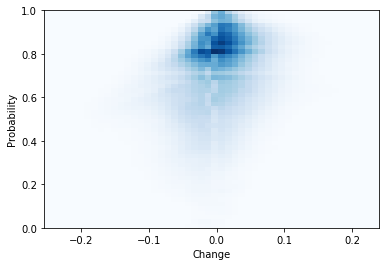

In [10]:
fig, ax = plt.subplots()

ax.hist2d(data['change'], data['probability_before'], cmap='Blues', bins=50)

ax.set_xlabel('Change')
ax.set_ylabel('Probability')

*Finding*: The changes are actually skewed to positive changes, which is less suggestive of the changes being due to the randomness

## Where are the changes localized
Which composition? Any particular systems

In [11]:
data.sort_values('change_abs', ascending=False)[:5]

,composition,probability_before,probability_after,change,change_abs
1005441,Ca0.36Mg0.52Cr0.12,0.4450,0.700,-0.2550,0.2550
881977,Ca0.4Mg0.48Cr0.12,0.4500,0.695,-0.2450,0.2450
1072233,Ca0.34Mg0.56Cr0.1,0.4375,0.680,-0.2425,0.2425
1740176,Mg0.68Al0.16In0.16,0.6550,0.415,0.2400,0.2400
823281,Ca0.42Mg0.46Cr0.12,0.4650,0.705,-0.2400,0.2400


*Finding*: The largest changes are those with Mg and Ca

Compute the systems with the largest average change

In [12]:
elem_re = re.compile('[A-Z][a-z]?')
data['system'] = data['composition'].apply(lambda x: tuple(sorted(elem_re.findall(x))))

In [13]:
system_freq = data.groupby('system').mean()

In [14]:
system_freq['system'] = system_freq.index

In [15]:
system_freq['above_10'] = data.groupby('system').apply(lambda x: sum(x['change_abs'] > 0.1) / len(x))

In [16]:
system_freq['change_75p'] = data.groupby('system').apply(lambda x: np.percentile(x['change_abs'], 75))

Get only the ternaries

In [17]:
system_freq['is_ternary'] = system_freq['system'].apply(len) == 3
system_freq = system_freq.query('is_ternary == True')

In [18]:
print('Average change for all ternaries %.2f%%'%(system_freq['change_abs'].mean() * 100))

Average change for all ternaries 3.59%


Get the ternaries that change the most

In [19]:
system_freq.sort_values('change_abs', ascending=False, inplace=True)

In [20]:
system_freq.head(7)

,probability_before,probability_after,change,change_abs,system,above_10,change_75p,is_ternary
system,,,,,,,,
"(In, Mg, Sn)",0.598042,0.489464,0.108578,0.111796,"(In, Mg, Sn)",0.621599,0.1525,True
"(Al, Mg, Sn)",0.626975,0.524388,0.102587,0.106142,"(Al, Mg, Sn)",0.607993,0.1400,True
"(In, Sn, Ta)",0.825176,0.720404,0.104773,0.104794,"(In, Sn, Ta)",0.498299,0.1325,True
"(In, Sn, Zr)",0.790527,0.687504,0.103023,0.103427,"(In, Sn, Zr)",0.642857,0.1275,True
"(Al, In, Mg)",0.602179,0.508720,0.093459,0.099713,"(Al, In, Mg)",0.516156,0.1450,True
"(In, Nb, Zr)",0.779124,0.681684,0.097440,0.097538,"(In, Nb, Zr)",0.505952,0.1225,True
"(In, Mg, Zr)",0.692500,0.597679,0.094821,0.096832,"(In, Mg, Zr)",0.525510,0.1275,True


Most of these system that change a lot contain In, which is not surprsing given that there is no In in the training set. These predictions are just unreliable. 

In [21]:
# Training set elements from another sheet
training_set_elems = 'Tb Gd Pd B Cr Ag Cu N Fe Mo Yb O Ge F Ru Mn Nb Zr Mg Nd Sm Si Co Al Hf Ni Ta Ti C'.split(" ")

In [22]:
system_freq['all_in_training'] = system_freq['system'].apply(lambda e: all(x in training_set_elems for x in e))

In [23]:
system_freq.query('all_in_training == True').head()

,probability_before,probability_after,change,change_abs,system,above_10,change_75p,is_ternary,all_in_training
system,,,,,,,,,
"(Ge, Mg, Si)",0.535227,0.480064,0.055164,0.063591,"(Ge, Mg, Si)",0.109694,0.0850,True,True
"(Cr, Fe, Mg)",0.566818,0.618418,-0.051601,0.060108,"(Cr, Fe, Mg)",0.210884,0.0775,True,True
"(Cr, Cu, Mg)",0.565974,0.619702,-0.053729,0.057819,"(Cr, Cu, Mg)",0.136054,0.0775,True,True
"(Cr, Mg, Mn)",0.515551,0.572066,-0.056516,0.057795,"(Cr, Mg, Mn)",0.090986,0.0775,True,True
"(B, Co, Mg)",0.686310,0.668053,0.018257,0.057432,"(B, Co, Mg)",0.128401,0.0825,True,True


*Finding*: Changes are indeed smaller for systems with only elements from the training set

In [24]:
covzr_score = system_freq[system_freq['system'] == ('Co', 'V', 'Zr')].iloc[0]
covzr_score

probability_before       0.905778
probability_after        0.906463
change               -0.000684524
change_abs               0.017551
system                (Co, V, Zr)
above_10               0.00510204
change_75p                 0.0225
is_ternary                   True
all_in_training             False
Name: (Co, V, Zr), dtype: object

99.01% of systems have a larger change than Co-V-Zr
97.14% of systems with only elements in training set have a larger change than Co-V-Zr


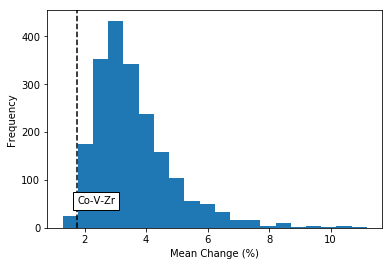

In [25]:
fig, ax = plt.subplots()

system_freq_all_in = system_freq.query('all_in_training == True')
print('%.2f%% of systems have a larger change than Co-V-Zr'%(np.mean(
    system_freq['change_abs'] > covzr_score['change_abs']) * 100
))
print('%.2f%% of systems with only elements in training set have a larger change than Co-V-Zr'%(np.mean(
    system_freq_all_in['change_abs'] > covzr_score['change_abs']) * 100
     ))
ax.hist(system_freq['change_abs'] * 100, bins=20)

ax.set_ylim(ax.get_ylim())

ax.plot([covzr_score['change_abs']*100,]*2, ax.get_ylim(), 'k--')
ax.text(covzr_score['change_abs']*100, 50, 'Co-V-Zr', bbox={'facecolor': 'w'})

ax.set_xlabel('Mean Change (%)')
ax.set_ylabel('Frequency')

68.08% of systems have a larger change than Co-V-Zr
49.11% of systems with only elements in training set have a larger change than Co-V-Zr


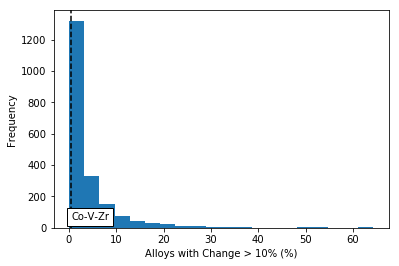

In [26]:
fig, ax = plt.subplots()

system_freq_all_in = system_freq.query('all_in_training == True')
print('%.2f%% of systems have a larger change than Co-V-Zr'%(np.mean(
    system_freq['above_10'] > covzr_score['above_10']) * 100
))
print('%.2f%% of systems with only elements in training set have a larger change than Co-V-Zr'%(np.mean(
    system_freq_all_in['above_10'] > covzr_score['above_10']) * 100
     ))
ax.hist(system_freq['above_10'] * 100, bins=20)

ax.set_ylim(ax.get_ylim())

ax.plot([covzr_score['above_10']*100,]*2, ax.get_ylim(), 'k--')
ax.text(covzr_score['above_10']*100, 50, 'Co-V-Zr', bbox={'facecolor': 'w'})

ax.set_xlabel('Alloys with Change > 10% (%)')
ax.set_ylabel('Frequency')

*Finding*: Co-V-Zr is not a typical system for its mean change